# <center> Anomaly Detection of DDoS Attacks using AI </center>

## I. Brief Intro
<br>
As part of my internship at YaneCode Digital, I'm working on a project takling anomaly detection in computer network where I focuse on Distributed Denial of Service (DDoS) attacks. Anomaly detection plays a crucial role in cybersecurity, aiming to identify unusual patterns and activities that deviate significantly from normal behavior within a network or system.
<br><br>
For this project, I am collecting network traffic data and logs from various sources. I then preprocess and transform the raw data to prepare it for analysis. Through exploratory data analysis, I gain insights into normal network behavior and identify potential features for distinguishing normal from anomalous traffic.

## II. Dataset

In this project, the challenge arose from the absence of recent datasets exclusively focused on DDoS attacks in the public domain. Instead, IDS datasets such as CSE-CIC-IDS2018-AWS,and Intrusion Detection Evaluation Dataset (CIC-IDS2017) were available. <br> <br>
 To enhance the dataset's variance, DDoS flows were extracted from different IDS datasets, each generated in distinct years using various experimental DDoS traffic generation tools. These extracted DDoS flows were then combined with "Benign" flows, which were separately extracted from the same base dataset. The result was a single, comprehensive dataset that includes both DDoS and normal network traffic, allowing for more diverse and accurate anomaly detection.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost

In [2]:

df = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

# Display the DataFrame using a scrollable style
df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_15876\1394350982.py:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,External IP
0,192.168.10.16-199.244.48.55-41936-443-6,192.168.10.16,41936,199.244.48.55,443,6,7/7/2017 3:30,143347,47,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,NaN
1,192.168.10.16-54.210.195.63-42970-80-6,192.168.10.16,42970,54.210.195.63,80,6,7/7/2017 3:30,50905,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,NaN
2,192.168.10.16-199.244.48.55-41944-443-6,192.168.10.16,41944,199.244.48.55,443,6,7/7/2017 3:30,143899,46,58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,NaN
3,192.168.10.3-192.168.10.17-53-12886-17,192.168.10.17,12886,192.168.10.3,53,17,7/7/2017 3:30,313,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,NaN
4,192.168.10.16-199.244.48.55-41942-443-6,192.168.10.16,41942,199.244.48.55,443,6,7/7/2017 3:30,142605,45,58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,NaN


### Data Preprocessing

In [3]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 225745 rows and 86 columns


In [4]:
# We Strip any leading or trailing white spaces from column names
df.columns = df.columns.str.strip()

# we then drop empty rows
df.dropna(subset=['Label'], inplace=True)

In [5]:

# We Get unique values of the 'Label' column
unique_labels = df['Label'].unique()

# then we Print the unique values
print(unique_labels)

# we get value counts of each unique value in the 'Label' column
label_counts = df['Label'].value_counts()

# finally we print the value counts
print(label_counts)

['BENIGN' 'DDoS']
Label
BENIGN    183910
DDoS       41835
Name: count, dtype: int64


### Exploratory data analysis 

In [6]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 225745 rows and 86 columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 86 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow ID                      225745 non-null  object 
 1   Source IP                    225745 non-null  object 
 2   Source Port                  225745 non-null  int64  
 3   Destination IP               225745 non-null  object 
 4   Destination Port             225745 non-null  int64  
 5   Protocol                     225745 non-null  int64  
 6   Timestamp                    225745 non-null  object 
 7   Flow Duration                225745 non-null  int64  
 8   Total Fwd Packets            225745 non-null  int64  
 9   Total Backward Packets       225745 non-null  int64  
 10  Total Length of Fwd Packets  225745 non-null  int64  
 11  Total Length of Bwd Packets  225745 non-null  int64  
 12  Fwd Packet Length Max        225745 non-null  int64  
 13 

         Source Port  Destination Port       Protocol  Flow Duration  \
count  225745.000000      225745.00000  225745.000000   2.257450e+05   
mean    38257.568402        8879.61946       7.600288   1.624165e+07   
std     23057.302075       19754.64740       3.881586   3.152437e+07   
min         0.000000           0.00000       0.000000  -1.000000e+00   
25%     18990.000000          80.00000       6.000000   7.118000e+04   
50%     49799.000000          80.00000       6.000000   1.452333e+06   
75%     58296.000000          80.00000       6.000000   8.805237e+06   
max     65534.000000       65532.00000      17.000000   1.199999e+08   

       Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  \
count      225745.000000           225745.000000                225745.000000   
mean            4.874916                4.572775                   939.463346   
std            15.422874               21.755356                  3249.403484   
min             1.000000   

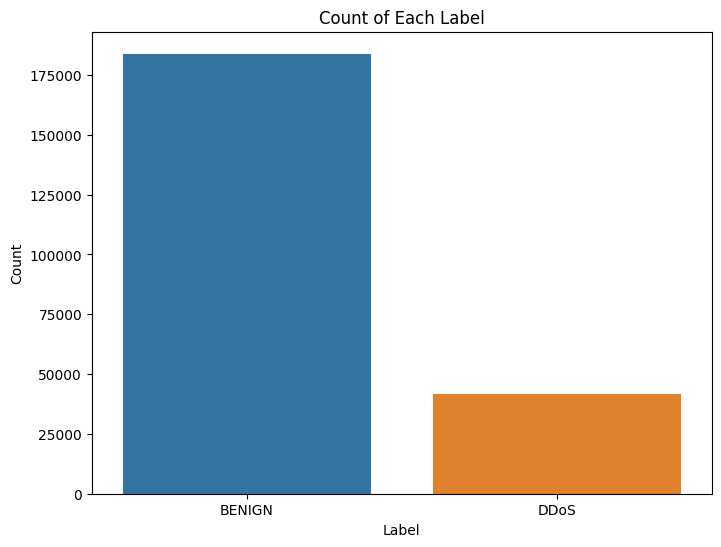

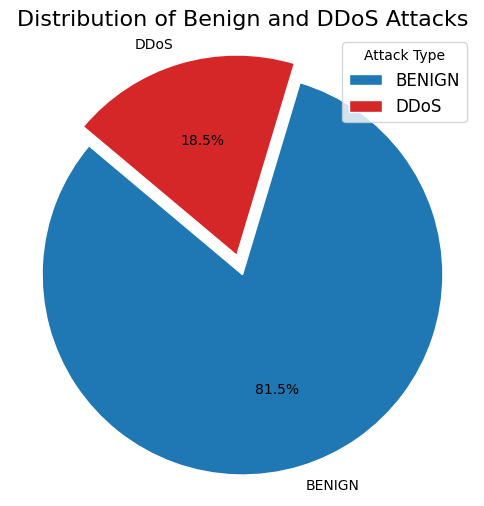

In [7]:

# Get a summary of the DataFrame
print(df.info())

# Show basic statistics of the numerical columns
print(df.describe())

# Check for missing values in the DataFrame
print(df.isnull().sum())

# Check the unique values in the 'Label' column
print(df['Label'].unique())

# Count the occurrences of each value in the 'Label' column
print(df['Label'].value_counts())


# Plot a count plot of categorical features (example: 'Label')
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=df)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.show()

# Create a pie chart
plt.figure(figsize=(6, 6))

# Define colors for the slices
colors = ['#1f77b4', '#d62728']

# Define the explode distance (separating the slices)
explode = (0.1, 0)

# Create the pie chart
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140, wedgeprops={'edgecolor': 'white'})

# Set a title and legend for the plot
plt.title('Distribution of Benign and DDoS Attacks', fontsize=16)
plt.legend(label_counts.index, title="Attack Type", loc="best", fontsize=12)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()




### Correlation Matrix

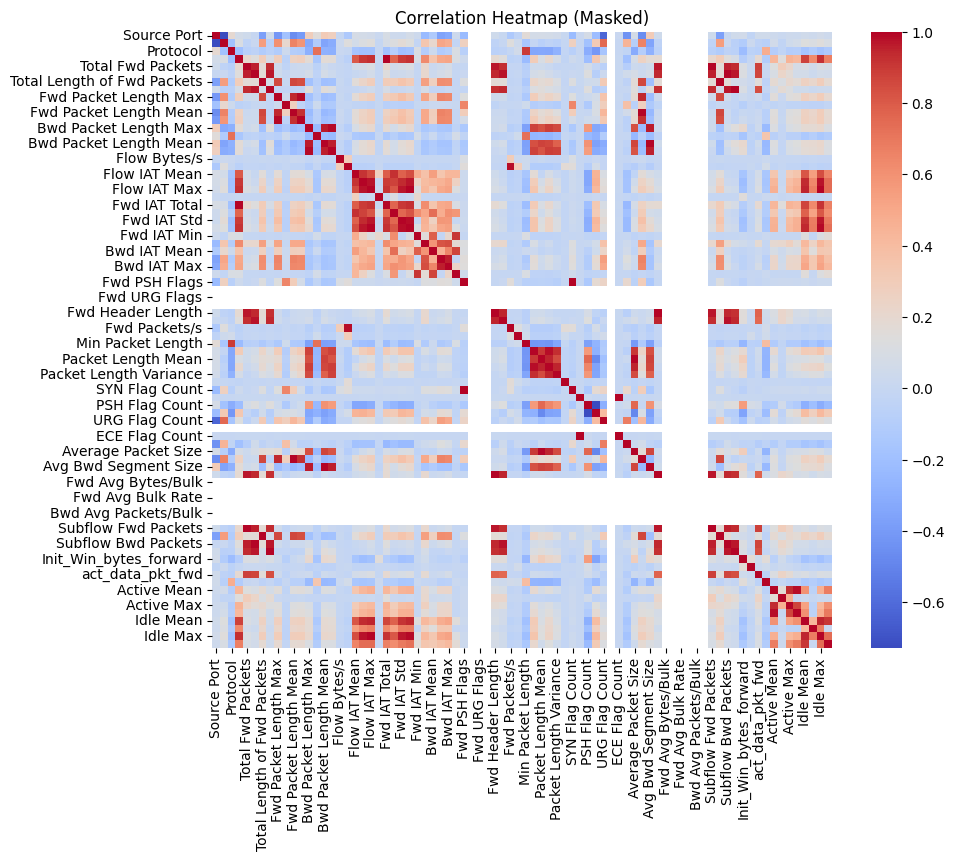

In [8]:
# Create a correlation matrix for numerical columns and visualize it using a heatmap

# Filter only numeric columns
numeric_data = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
# Assuming you have a DataFrame 'data' with numeric columns

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a correlation heatmap without showing numeric values
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (Masked)')
plt.show()


In [8]:



# Drop columns that won't be used as features (e.g., Flow ID, Timestamp)
df.drop(columns=['Flow ID', 'Timestamp','Source IP', 'Destination IP', 'External IP'], inplace=True)

# Separate features (X) and labels (y)
X = df.drop(columns=['Label'])  # Features
y = df['Label']  # Labels





In [9]:
X.replace('Infinity',0.0, inplace=True)
X.replace('NaN',0.0, inplace=True)
X.replace("Infinity", 0, inplace=True)
X['Flow Bytes/s'].replace("Infinity", 0,inplace=True)
X['Flow Bytes/s'].replace(np.nan, 0,inplace=True)


X["Bwd Avg Bulk Rate"].replace("Infinity", 0, inplace=True)
X["Bwd Avg Bulk Rate"].replace(",,", 0, inplace=True)
X["Bwd Avg Bulk Rate"].replace(np.nan, 0, inplace=True)

X["Bwd Avg Packets/Bulk"].replace("Infinity", 0, inplace=True)
X["Bwd Avg Packets/Bulk"].replace(",,", 0, inplace=True)
X["Bwd Avg Packets/Bulk"].replace(np.nan, 0, inplace=True)


X["Bwd Avg Bytes/Bulk"].replace("Infinity", 0, inplace=True)
X["Bwd Avg Bytes/Bulk"].replace(",,", 0, inplace=True)
X["Bwd Avg Bytes/Bulk"].replace(np.nan, 0, inplace=True)


X["Fwd Avg Bulk Rate"].replace("Infinity", 0, inplace=True)
X["Fwd Avg Bulk Rate"].replace(",,", 0, inplace=True)
X["Fwd Avg Bulk Rate"].replace(np.nan, 0, inplace=True)


X["Fwd Avg Packets/Bulk"].replace("Infinity", 0, inplace=True)
X["Fwd Avg Packets/Bulk"].replace(",,", 0, inplace=True)
X["Fwd Avg Packets/Bulk"].replace(np.nan, 0, inplace=True)


X["Fwd Avg Bytes/Bulk"].replace("Infinity", 0, inplace=True)
X["Fwd Avg Bytes/Bulk"].replace(",,", 0, inplace=True)
X["Fwd Avg Bytes/Bulk"].replace(np.nan, 0, inplace=True)


X["CWE Flag Count"].replace("Infinity", 0, inplace=True)
X["CWE Flag Count"].replace(",,", 0, inplace=True)
X["CWE Flag Count"].replace(np.nan, 0, inplace=True)

X["Bwd URG Flags"].replace("Infinity", 0, inplace=True)
X["Bwd URG Flags"].replace(",,", 0, inplace=True)
X["Bwd URG Flags"].replace(np.nan, 0, inplace=True)

X["Bwd PSH Flags"].replace("Infinity", 0, inplace=True)
X["Bwd PSH Flags"].replace(",,", 0, inplace=True)
X["Bwd PSH Flags"].replace(np.nan, 0, inplace=True)

X["Fwd URG Flags"].replace("Infinity", 0, inplace=True)
X["Fwd URG Flags"].replace(",,", 0, inplace=True)
X["Fwd URG Flags"].replace(np.nan, 0, inplace=True)

X["Flow Bytes/s"]=df["Flow Bytes/s"].astype("float64")
X['Flow Packets/s']=df["Flow Packets/s"].astype("float64")

X['Bwd Avg Bulk Rate']=df["Bwd Avg Bulk Rate"].astype("float64")
X['Bwd Avg Packets/Bulk']=df["Bwd Avg Packets/Bulk"].astype("float64")
X['Bwd Avg Bytes/Bulk']=df["Bwd Avg Bytes/Bulk"].astype("float64")
X['Fwd Avg Bulk Rate']=df["Fwd Avg Bulk Rate"].astype("float64")
X['Fwd Avg Packets/Bulk']=df["Fwd Avg Packets/Bulk"].astype("float64")
X['Fwd Avg Bytes/Bulk']=df["Fwd Avg Bytes/Bulk"].astype("float64")
X['CWE Flag Count']=df["CWE Flag Count"].astype("float64")
X['Bwd URG Flags']=df["Bwd URG Flags"].astype("float64")
X['Bwd PSH Flags']=df["Bwd PSH Flags"].astype("float64")
X['Fwd URG Flags']=df["Fwd URG Flags"].astype("float64")


In [10]:
ddos_indices = np.where(y == "DDoS")[0]
features=["Fwd Packet Length Max","Flow IAT Std","Fwd Packet Length Std" ,"Fwd IAT Total", "Fwd Packet Length Mean", "Flow IAT Mean", "Bwd Packet Length Mean", "Flow IAT Max", "Bwd Packet Length Std", ]
X=X[features].copy()
# Get the corresponding rows from X_test where y_pred is "DDoS"
x_ddos = X.iloc[ddos_indices]
print(x_ddos)

        Fwd Packet Length Max  Flow IAT Std  Fwd Packet Length Std  \
18869                      20  4.308658e+05              10.263203   
18870                       6  2.552043e+06               0.000000   
18871                      20  3.777253e+05              10.263203   
18872                      20  2.110000e+07               5.656854   
18873                      20  2.268247e+05              10.263203   
...                       ...           ...                    ...   
196985                      6  0.000000e+00               0.000000   
196986                      6  0.000000e+00               0.000000   
196987                      6  0.000000e+00               0.000000   
196988                      6  7.801509e+03               0.000000   
196989                      6  0.000000e+00               0.000000   

        Fwd IAT Total  Fwd Packet Length Mean  Flow IAT Mean  \
18869           747.0                8.666667   1.437547e+05   
18870       4421382.0          

In [11]:
cols = list(X.columns)
for col in cols:
    X[col] = stats.zscore(X[col])

X.replace('NaN',0.0, inplace=True)
features=["Fwd Packet Length Max","Flow IAT Std","Fwd Packet Length Std" ,"Fwd IAT Total", "Fwd Packet Length Mean", "Flow IAT Mean", "Bwd Packet Length Mean", "Flow IAT Max", "Bwd Packet Length Std", ]
X=X[features].copy()
X.head()

,Fwd Packet Length Max,Flow IAT Std,Fwd Packet Length Std,Fwd IAT Total,Fwd Packet Length Mean,Flow IAT Mean,Bwd Packet Length Mean,Flow IAT Max,Bwd Packet Length Std
0,0.016879,-0.556685,-0.131222,-0.482570,-0.270623,-0.584558,0.822959,-0.504340,-0.235451
1,-0.288895,-0.557350,-0.269507,-0.487106,-0.326459,-0.566216,-0.794893,-0.503297,-0.709771
2,0.016879,-0.556669,-0.129795,-0.482553,-0.269409,-0.584541,0.900816,-0.504329,-0.165690
3,-0.264755,-0.557328,-0.269507,-0.487105,-0.237331,-0.585020,-0.702956,-0.505192,-0.709771
4,0.016879,-0.556672,-0.128324,-0.482595,-0.268141,-0.584541,0.878747,-0.504334,-0.147962


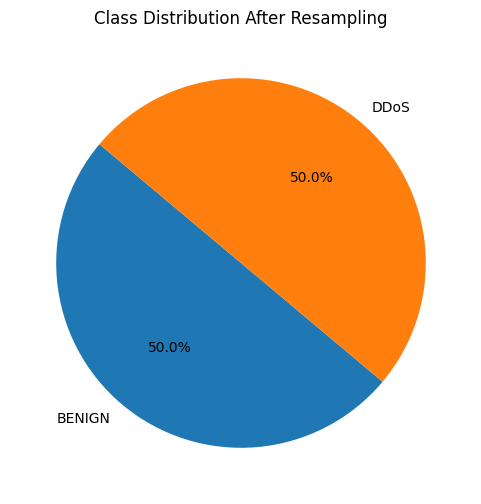

In [12]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Assuming you have your feature matrix X and target vector y
# X should be a 2D array or DataFrame, and y should be a 1D array or Series

# Instantiate the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and apply the resampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Now, X_resampled and y_resampled contain the resampled data
# You can use these for training your model
import matplotlib.pyplot as plt

# Assuming you have resampled data in X_resampled and y_resampled
# Calculate the class distribution of the resampled data
class_counts = [len(np.where(y_resampled == class_label)[0]) for class_label in np.unique(y_resampled)]
class_labels = np.unique(y_resampled)

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution After Resampling')
plt.show()

X

In [27]:
X_resampled.head()

,Fwd Packet Length Max,Flow IAT Std,Fwd Packet Length Std,Fwd IAT Total,Fwd Packet Length Mean,Flow IAT Mean,Bwd Packet Length Mean,Flow IAT Max,Bwd Packet Length Std
0,0.016879,-0.556685,-0.131222,-0.482570,-0.270623,-0.584558,0.822959,-0.504340,-0.235451
1,-0.288895,-0.557350,-0.269507,-0.487106,-0.326459,-0.566216,-0.794893,-0.503297,-0.709771
2,0.016879,-0.556669,-0.129795,-0.482553,-0.269409,-0.584541,0.900816,-0.504329,-0.165690
3,-0.264755,-0.557328,-0.269507,-0.487105,-0.237331,-0.585020,-0.702956,-0.505192,-0.709771
4,0.016879,-0.556672,-0.128324,-0.482595,-0.268141,-0.584541,0.878747,-0.504334,-0.147962


In [17]:
y_resampled.value_counts()

Label
BENIGN    183910
DDoS      183910
Name: count, dtype: int64

In [28]:
ddos_indices = np.where(y_pred == "DDoS")[0]

# Get the corresponding rows from X_test where y_pred is "DDoS"
x_ddos = X_test.iloc[ddos_indices]
print(x_ddos)

        Fwd Packet Length Max  Flow IAT Std  Fwd Packet Length Std  \
66343               -0.285676     -0.295137              -0.269507   
160848              -0.278166      2.814114              -0.262413   
28596               -0.278166     -0.527188              -0.256636   
44243               -0.285676     -0.407499              -0.269507   
161293              -0.278166      2.945299              -0.262413   
...                       ...           ...                    ...   
35792               -0.285676      0.024582              -0.269507   
123854              -0.278166     -0.555199              -0.256636   
107588              -0.278166      2.354965              -0.262413   
126777              -0.285676     -0.170374              -0.269507   
188810              -0.285676     -0.086559              -0.269507   

        Fwd IAT Total  Fwd Packet Length Mean  Flow IAT Mean  \
66343       -0.360592               -0.314576      -0.215011   
160848       2.588047          

In [32]:
X.fillna(X.mean(), inplace=True)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.head()

,Fwd Packet Length Max,Flow IAT Std,Fwd Packet Length Std,Fwd IAT Total,Fwd Packet Length Mean,Flow IAT Mean,Bwd Packet Length Mean,Flow IAT Max,Bwd Packet Length Std
0,0.016879,-0.556685,-0.131222,-0.482570,-0.270623,-0.584558,0.822959,-0.504340,-0.235451
1,-0.288895,-0.557350,-0.269507,-0.487106,-0.326459,-0.566216,-0.794893,-0.503297,-0.709771
2,0.016879,-0.556669,-0.129795,-0.482553,-0.269409,-0.584541,0.900816,-0.504329,-0.165690
3,-0.264755,-0.557328,-0.269507,-0.487105,-0.237331,-0.585020,-0.702956,-0.505192,-0.709771
4,0.016879,-0.556672,-0.128324,-0.482595,-0.268141,-0.584541,0.878747,-0.504334,-0.147962


In [19]:
# Split the data into training and testing sets
X_train0, X_test0, y_train0, y_test0 = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [33]:
t1=time.time()

for i in range(1,len(X_train.columns)+5):
    knn=KNeighborsClassifier(n_neighbors=i)
    model_knn=knn.fit(X_train,y_train)
    yhat=model_knn.predict(X_test)
    print("for " , i,  " as K, accuracy is : ", accuracy_score(y_test, yhat))
t2=time.time()
print(" time for ", i ," k's :: ", (t2-t1)/60 , " minutes")

for  1  as K, accuracy is :  0.8429422578573169
for  2  as K, accuracy is :  0.8584021794502646
for  3  as K, accuracy is :  0.8454229329553257
for  4  as K, accuracy is :  0.8562758865091142
for  5  as K, accuracy is :  0.8476378214356907
for  6  as K, accuracy is :  0.8577155640213515
for  7  as K, accuracy is :  0.8525327249772974
for  8  as K, accuracy is :  0.8587787104919268
for  9  as K, accuracy is :  0.8551019956145208
for  10  as K, accuracy is :  0.8587122638375158
for  11  as K, accuracy is :  0.8559658021218631
for  12  as K, accuracy is :  0.8578706062149771
for  13  as K, accuracy is :  0.855655717734612
 time for  13  k's ::  0.8323528170585632  minutes


In [34]:

from sklearn.model_selection import cross_val_score


t1 = time.time()

best_accuracy = 0
best_k = None

for i in range(1, len(X_train.columns) + 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    # Use cross_val_score for cross-validation
    scores = cross_val_score(knn, X_train, y_train, cv=5)  # You can adjust the number of folds (cv) as needed
    avg_accuracy = np.mean(scores)
    print("For", i, "as K, average accuracy is:", avg_accuracy)
    
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_k = i

t2 = time.time()

print("Best K:", best_k)
print("Time taken:", (t2 - t1) / 60, "minutes")


For 1 as K, average accuracy is: 0.838833645041368
For 2 as K, average accuracy is: 0.8578595325216506
For 3 as K, average accuracy is: 0.8434904379846648
For 4 as K, average accuracy is: 0.8566856401858788
For 5 as K, average accuracy is: 0.8482912054551314
For 6 as K, average accuracy is: 0.857211682638695
For 7 as K, average accuracy is: 0.8504064370460913
For 8 as K, average accuracy is: 0.8571784605072373
For 9 as K, average accuracy is: 0.8526545415261235
For 10 as K, average accuracy is: 0.8573113479599564
For 11 as K, average accuracy is: 0.8539281014826805
For 12 as K, average accuracy is: 0.8576934163455077
For 13 as K, average accuracy is: 0.8549414155073773
For 14 as K, average accuracy is: 0.8577543276490041
For 15 as K, average accuracy is: 0.855605878525633
For 16 as K, average accuracy is: 0.8579813555885482
For 17 as K, average accuracy is: 0.8562205183879532
For 18 as K, average accuracy is: 0.8583412758864609
For 19 as K, average accuracy is: 0.8564309302794684
Best 

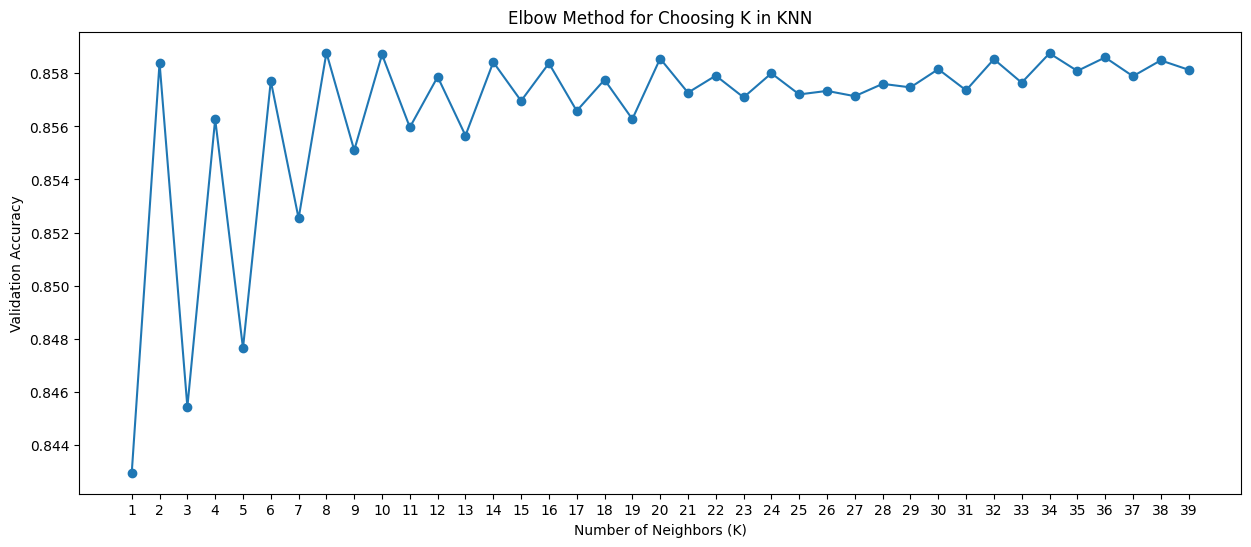

In [35]:
# Initialize lists to store K values and corresponding validation accuracies
k_values = []
val_accuracies = []

# Loop through different K values and compute validation accuracies
for k in range(1, 40 ):
    knn = KNeighborsClassifier(n_neighbors=k)
    model_knn = knn.fit(X_train, y_train)
    y_val_pred = model_knn.predict(X_test)
    val_accuracy = accuracy_score(y_test, y_val_pred)
    
    k_values.append(k)
    val_accuracies.append(val_accuracy)

# Plot the elbow curve
plt.figure(figsize=(15, 6))
plt.plot(k_values, val_accuracies, marker='o')
plt.title('Elbow Method for Choosing K in KNN')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Validation Accuracy')
plt.xticks(k_values)
plt.show()

In [49]:
print("Optimal k is ", k_values[np.argmax(val_accuracies)], "it's accuracy is", max(val_accuracies))
Acc=[]
Acc.append(max(val_accuracies))

Optimal k is  8 it's accuracy is 0.8587787104919268


In [92]:
knn = KNeighborsClassifier(n_neighbors=8)  # Use the best K value you found
model_knn = knn.fit(X_train, y_train)
y_val_pred = model_knn.predict(X_test)
row_10 = X.iloc[10]
row_10_reshaped = row_10.values.reshape(1, -1)  # Reshape the row to a 2D array

predicted_label = model_knn.predict(row_10_reshaped)
print("The predicted label is",predicted_label[0], "and the real one is", y_test.iloc[10])


The predicted label is BENIGN and the real one is BENIGN


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


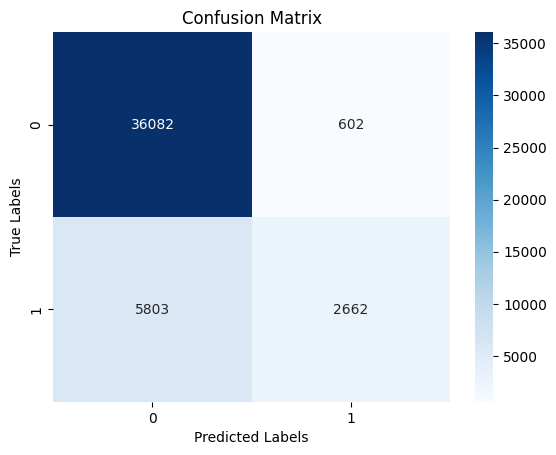

In [37]:
conf_matrix = confusion_matrix(y_test, y_val_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [50]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train0, y_train0)

y_pred = rf_classifier.predict(X_test0)

accuracy = accuracy_score(y_test0, y_pred)
classification_rep = classification_report(y_test0, y_pred)
print("accuracy is",accuracy)
print(classification_rep)
Acc.append(accuracy)


accuracy is 0.9461421347398183
              precision    recall  f1-score   support

      BENIGN       0.99      0.90      0.94     36827
        DDoS       0.91      0.99      0.95     36737

    accuracy                           0.95     73564
   macro avg       0.95      0.95      0.95     73564
weighted avg       0.95      0.95      0.95     73564



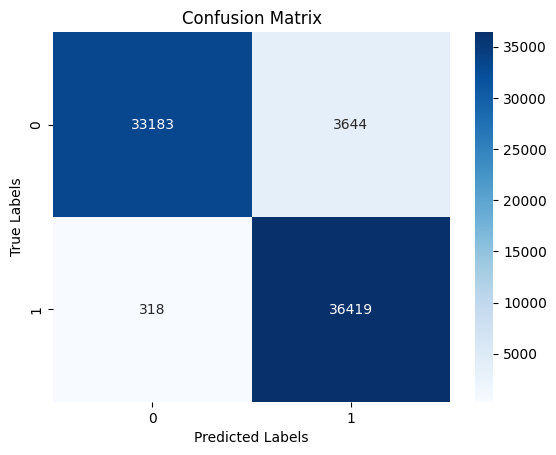

In [40]:
conf_matrix = confusion_matrix(y_test0, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [51]:
# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
dt_classifier.fit(X_train0, y_train0)

y_pred0 = dt_classifier.predict(X_test0)

accuracy = accuracy_score(y_test0, y_pred0)
classification_rep = classification_report(y_test0, y_pred0)

print("accuracy is",accuracy)
print(classification_rep)
Acc.append(accuracy)

accuracy is 0.947392746452069
              precision    recall  f1-score   support

      BENIGN       0.99      0.90      0.95     36827
        DDoS       0.91      0.99      0.95     36737

    accuracy                           0.95     73564
   macro avg       0.95      0.95      0.95     73564
weighted avg       0.95      0.95      0.95     73564



In [52]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training set
y_train_encoded = label_encoder.fit_transform(y_train0)

# Transform the labels in the test set
y_test_encoded = label_encoder.transform(y_test0)

# Initialize the XGBoost classifier
model1 = xgboost.XGBClassifier()

# Train the classifier on the training data with the encoded target variable
model1.fit(X_train0, y_train_encoded)

# Make predictions
y_pred_encoded = model1.predict(X_test0)

# Decode the predicted labels if needed
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
classification_rep = classification_report(y_test_encoded, y_pred_encoded)

print("accuracy is", accuracy)
print(classification_rep)
Acc.append(accuracy)

accuracy is 0.828815725082921
              precision    recall  f1-score   support

           0       0.95      0.70      0.80     36827
           1       0.76      0.96      0.85     36737

    accuracy                           0.83     73564
   macro avg       0.85      0.83      0.83     73564
weighted avg       0.85      0.83      0.83     73564



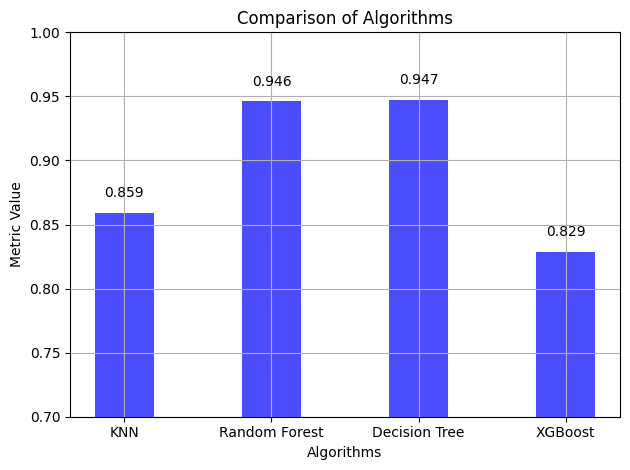

In [53]:


# List of algorithm names
algorithms = ["KNN",'Random Forest','Decision Tree','XGBoost', ]

# Create a bar chart
bars = plt.bar(algorithms, Acc, width=0.4, align='center', alpha=0.7, color='b')

# Label the axes and add a title
plt.xlabel('Algorithms')
plt.ylabel('Metric Value')
plt.title('Comparison of Algorithms')

plt.ylim(0.7, 1.0)

# Add text labels above each bar to display the numeric values
for bar, value in zip(bars, Acc):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
import pickle
#dt_classifier refering to the Decision Tree algorithm

with open("model.pkl", "wb") as file:
    pickle.dump(dt_classifier, file)
